In [192]:
import xarray as xr
import regionmask
import geopandas as gpd
import pandas as pd

# Abertura do arquivo de precipitação

In [193]:
# Diretório dos arquivos.
#DIRETORIO_DADOS = '../input/precipitacao/MERGE_CPTEC'
DIRETORIO_DADOS = '../input/precipitacao/CPC'

# Abertura do arquivo.
#ds = xr.open_mfdataset(f'{DIRETORIO_DADOS}/2022/??/MERGE_CPTEC_2022????.nc')
#ds = xr.open_mfdataset(f'{DIRETORIO_DADOS}/????/??/MERGE_CPTEC_????????.nc')
ds = xr.open_mfdataset(f'{DIRETORIO_DADOS}/precip.????.nc')

# Importação de variáveis.
prec = ds['precip']
lat = ds['lat']
lon = ds['lon']

In [194]:
prec

<xarray.DataArray 'precip' (time: 11688, lat: 31, lon: 22)>
dask.array<concatenate, shape=(11688, 31, 22), dtype=float32, chunksize=(366, 31, 22), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2022-12-31
  * lon      (lon) float32 315.2 315.8 316.2 316.8 ... 324.2 324.8 325.2 325.8
  * lat      (lat) float32 -2.25 -2.75 -3.25 -3.75 ... -16.25 -16.75 -17.25
Attributes:
    long_name:     Daily total of precipitation
    units:         mm
    var_desc:      Precipitation
    level_desc:    Surface
    statistic:     Total
    parent_stat:   Other
    cell_methods:  time: sum
    avg_period:    0000-00-01 00:00:00
    actual_range:  [  0.     970.5962]
    dataset:       CPC Global Precipitation

# Abertura do arquivo shapefile

In [195]:
# Nome do arquivo shapefile.
Nome_Arquivo_Shapefile = '../input/shapefile/caatinga_contorno/caatinga.shp'

# Leitura do arquivo shapefile.
arquivo_shp = gpd.read_file(Nome_Arquivo_Shapefile)

In [196]:
arquivo_shp

,gid,nome,shape_area,shape_len,geometry
0,1,Caatinga,67.971323,72.915234,"POLYGON ((-40.49531 -2.78574, -40.49173 -2.788..."


<AxesSubplot:>

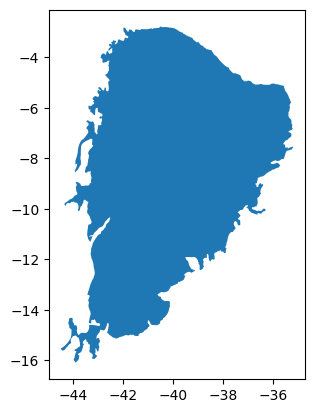

In [197]:
arquivo_shp.plot()

## Criação da máscara para aplicar na variável de interesse

In [198]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.html

# Domínio espacial do arquivo shapefile.
dominio_shapefile = regionmask.Regions(
    outlines=arquivo_shp.geometry.values,
    numbers=[0],
    names={0:'Bioma Caatinga'},
    abbrevs={0:'Caatinga'},
    name='Bioma_Caatinga', 
)

dominio_shapefile

<regionmask.Regions 'Bioma_Caatinga'>
overlap:  False

Regions:
0 Caatinga Bioma Caatinga

[1 regions]

In [199]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.mask.html#regionmask.Regions.mask

# Cria a máscara que será aplicada na variável de interesse.
mascara = dominio_shapefile.mask(
    lon_or_obj=lon,
    lat=lat,
    lon_name='longitude',
    lat_name='latitutde',
)

/home/gui/anaconda3/envs/cbagro/lib/python3.9/site-packages/regionmask/core/mask.py:166: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


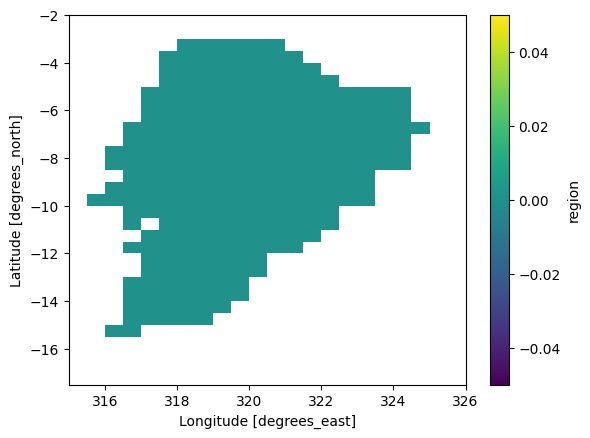

In [200]:
# Plot básico da máscara. NÃO É A VARIÁVEL A SER UTILIZADA!
mascara.plot()

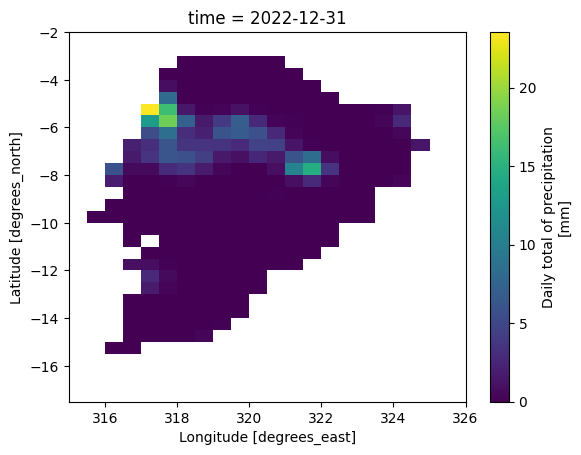

In [201]:
# Aplica a máscara na variável de interesse.
dado_mascarado = prec.where(mascara == mascara)

# Plot básico da variável mascarada. Objetivo deste plot: apenas visualizar
# a variável mascarada para ser se tudo está correto.
# Para a geração de um gráfico mais elaborado, utilizar a biblioteca Matplotlib.
dado_mascarado[-1,:,:].plot()

## Cálculo da média espacial

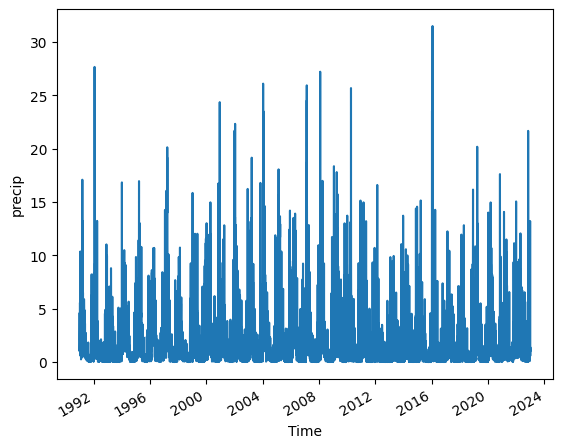

In [202]:
# Os nomes 'latitude' e 'longitude fazem parte do seu arquivo.
media_area = dado_mascarado.mean(dim=('lat', 'lon'))

media_area.plot()

# Criação do DataFrame para armazenar a variável

In [203]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

df1 = pd.DataFrame(data=media_area, index=prec.time, columns=['Chuva'])

df1.index.name = 'Dia'

df2 = df1.copy()

In [204]:
df1

,Chuva
Dia,
1991-01-01,1.083005
1991-01-02,1.132334
1991-01-03,1.101605
1991-01-04,1.662441
1991-01-05,1.765939
...,...
2022-12-27,0.583862
2022-12-28,0.579153
2022-12-29,1.396807


In [205]:
df1.describe()

,Chuva
count,11687.000000
mean,1.942385
std,2.798179
min,0.000000
25%,0.260504
50%,0.857347
75%,2.442850
max,31.495855


<AxesSubplot:xlabel='Dia'>

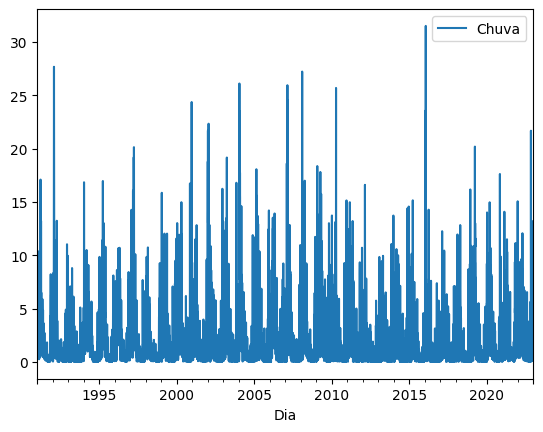

In [206]:
df1.plot()

# Algumas transformações na variável

## Acumulado semanal de precipitação

In [207]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

# A semana começa no domingo.
# 2022-01-02 = domingo -> soma todos os dias até completar domingo.
# 2022-01-09 = domingo -> soma todos os dias entre 03 e 09 (7 dias).

acumulado_semanal = df1.resample('W').sum()

acumulado_semanal

,Chuva
Dia,
1991-01-06,9.129289
1991-01-13,21.347733
1991-01-20,34.693554
1991-01-27,30.552475
1991-02-03,12.096516
...,...
2022-12-04,41.211758
2022-12-11,11.958293
2022-12-18,17.074450


## Acumulado mensal

In [208]:
acumulado_mensal = df1.resample('MS').sum()

acumulado_mensal

,Chuva
Dia,
1991-01-01,100.099648
1991-02-01,79.893944
1991-03-01,164.202332
1991-04-01,71.712448
1991-05-01,56.974304
...,...
2022-08-01,35.391964
2022-09-01,14.892078
2022-10-01,16.885502


## Acumulado sazonal

In [209]:
acumulado_sazonal = df1.resample('QS-DEC').sum()

## Acumulado anual

In [210]:
acumulado_anual = df1.resample('YS').sum()

acumulado_anual

,Chuva
Dia,
1991-01-01,648.670715
1992-01-01,741.301758
1993-01-01,366.835632
1994-01-01,773.841187
1995-01-01,803.388306
1996-01-01,742.837341
1997-01-01,785.225586
1998-01-01,479.360748
1999-01-01,777.132812


## Média móvel

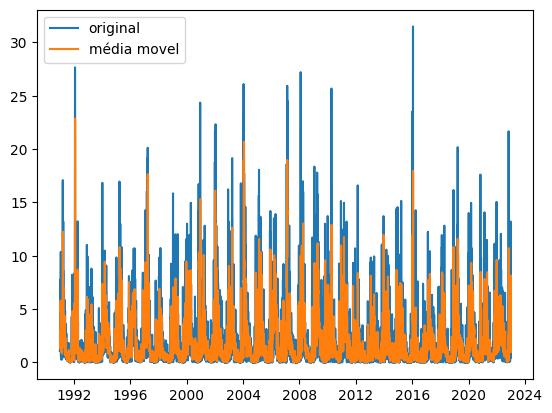

In [211]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

# Média móvel com janela deslizante.
media_movel1 = df1.rolling(window=5).mean()

import matplotlib.pyplot as plt 

plt.plot(df1, label='original')
plt.plot(media_movel1, label='média movel')
plt.legend()

In [212]:
# Média móvel com resample. Janela temporal fixa.
media_movel2 = df1.resample('5D').mean()

media_movel2

,Chuva
Dia,
1991-01-01,1.349065
1991-01-06,2.798643
1991-01-11,4.138704
1991-01-16,4.747704
1991-01-21,5.576074
...,...
2022-12-09,1.191073
2022-12-14,3.208421
2022-12-19,2.969979


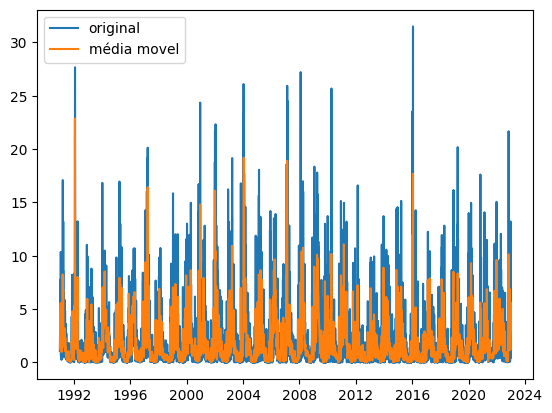

In [213]:
import matplotlib.pyplot as plt 

plt.plot(df1, label='original')
plt.plot(media_movel2, label='média movel')
plt.legend()

## Soma cumulativa

<AxesSubplot:xlabel='Dia'>

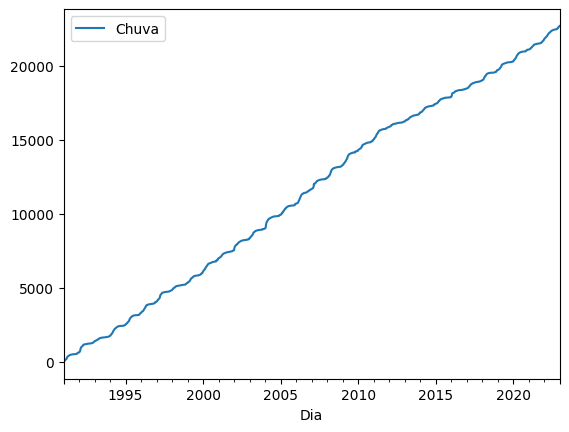

In [214]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html

df1.cumsum().plot()

## Conta a quantidade de valores ausente da variável

In [215]:
df1.isnull().sum()

Chuva    1
dtype: int64

## Compartimentalização (binning)

In [216]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.cut.html

bins1 = [0, 2.5, 7.6, 15, 30, 50, 75, 100]

chuva1 = pd.cut(df1['Chuva'], bins1, right=False)

chuva1.describe

<bound method NDFrame.describe of Dia
1991-01-01    [0.0, 2.5)
1991-01-02    [0.0, 2.5)
1991-01-03    [0.0, 2.5)
1991-01-04    [0.0, 2.5)
1991-01-05    [0.0, 2.5)
                 ...    
2022-12-27    [0.0, 2.5)
2022-12-28    [0.0, 2.5)
2022-12-29    [0.0, 2.5)
2022-12-30    [0.0, 2.5)
2022-12-31    [0.0, 2.5)
Name: Chuva, Length: 11688, dtype: category
Categories (7, interval[float64, left]): [[0.0, 2.5) < [2.5, 7.6) < [7.6, 15.0) < [15.0, 30.0) < [30.0, 50.0) < [50.0, 75.0) < [75.0, 100.0)]>

In [217]:
pd.value_counts(chuva1)

Chuva
[0.0, 2.5)       8837
[2.5, 7.6)       2268
[7.6, 15.0)       513
[15.0, 30.0)       68
[30.0, 50.0)        1
[50.0, 75.0)        0
[75.0, 100.0)       0
Name: count, dtype: int64

<AxesSubplot:xlabel='Chuva'>

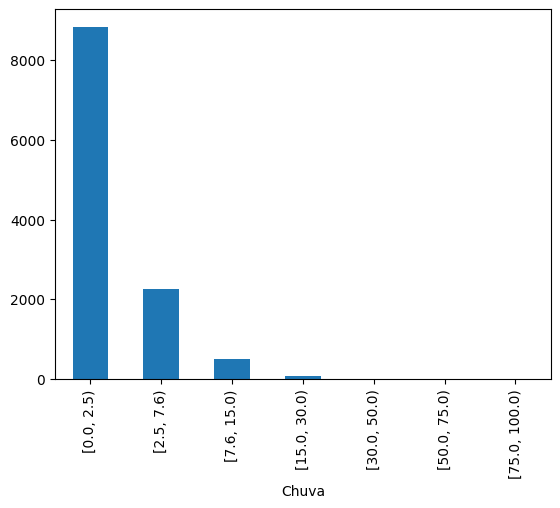

In [218]:
pd.value_counts(chuva1).plot.bar()

In [219]:
df1['bin'] = chuva1

df1

,Chuva,bin
Dia,,
1991-01-01,1.083005,"[0.0, 2.5)"
1991-01-02,1.132334,"[0.0, 2.5)"
1991-01-03,1.101605,"[0.0, 2.5)"
1991-01-04,1.662441,"[0.0, 2.5)"
1991-01-05,1.765939,"[0.0, 2.5)"
...,...,...
2022-12-27,0.583862,"[0.0, 2.5)"
2022-12-28,0.579153,"[0.0, 2.5)"
2022-12-29,1.396807,"[0.0, 2.5)"


In [220]:
# Observação: A quantidade de rótulos (nome2) tem que ser uma quantidade menor que a quantidade de classes (bins2).
nome2 = ['Muito Fraca', 'Fraca', 'Moderada', 'Moderadamente Forte', 'Forte', 'Muito Forte', 'Extremamente Forte']
bins2 = [0, 2.5, 7.6, 15, 30, 50, 75, 100]

chuva2 = pd.cut(df1['Chuva'], bins2, labels=nome2)

chuva2.describe

<bound method NDFrame.describe of Dia
1991-01-01    Muito Fraca
1991-01-02    Muito Fraca
1991-01-03    Muito Fraca
1991-01-04    Muito Fraca
1991-01-05    Muito Fraca
                 ...     
2022-12-27    Muito Fraca
2022-12-28    Muito Fraca
2022-12-29    Muito Fraca
2022-12-30    Muito Fraca
2022-12-31    Muito Fraca
Name: Chuva, Length: 11688, dtype: category
Categories (7, object): ['Muito Fraca' < 'Fraca' < 'Moderada' < 'Moderadamente Forte' < 'Forte' < 'Muito Forte' < 'Extremamente Forte']>

In [221]:
pd.value_counts(chuva2)

Chuva
Muito Fraca            8809
Fraca                  2268
Moderada                513
Moderadamente Forte      68
Forte                     1
Muito Forte               0
Extremamente Forte        0
Name: count, dtype: int64

<AxesSubplot:xlabel='Chuva'>

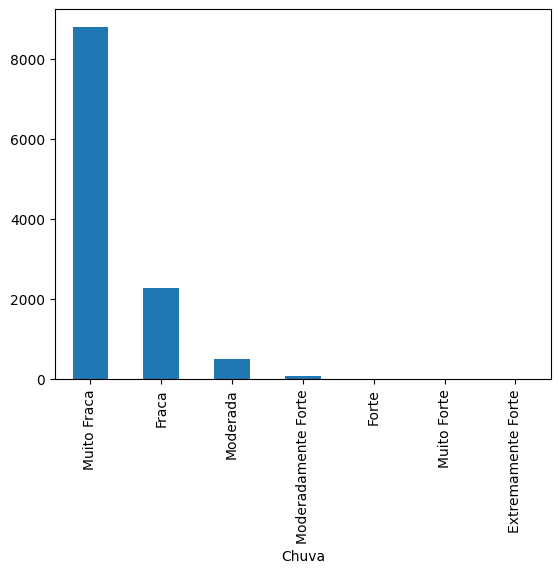

In [222]:
pd.value_counts(chuva2).plot.bar()

In [223]:
df1['Classificacao'] = chuva2

df1

,Chuva,bin,Classificacao
Dia,,,
1991-01-01,1.083005,"[0.0, 2.5)",Muito Fraca
1991-01-02,1.132334,"[0.0, 2.5)",Muito Fraca
1991-01-03,1.101605,"[0.0, 2.5)",Muito Fraca
1991-01-04,1.662441,"[0.0, 2.5)",Muito Fraca
1991-01-05,1.765939,"[0.0, 2.5)",Muito Fraca
...,...,...,...
2022-12-27,0.583862,"[0.0, 2.5)",Muito Fraca
2022-12-28,0.579153,"[0.0, 2.5)",Muito Fraca
2022-12-29,1.396807,"[0.0, 2.5)",Muito Fraca


In [224]:
df1

,Chuva,bin,Classificacao
Dia,,,
1991-01-01,1.083005,"[0.0, 2.5)",Muito Fraca
1991-01-02,1.132334,"[0.0, 2.5)",Muito Fraca
1991-01-03,1.101605,"[0.0, 2.5)",Muito Fraca
1991-01-04,1.662441,"[0.0, 2.5)",Muito Fraca
1991-01-05,1.765939,"[0.0, 2.5)",Muito Fraca
...,...,...,...
2022-12-27,0.583862,"[0.0, 2.5)",Muito Fraca
2022-12-28,0.579153,"[0.0, 2.5)",Muito Fraca
2022-12-29,1.396807,"[0.0, 2.5)",Muito Fraca


In [225]:
df1.drop(columns=['bin', 'Classificacao'])

,Chuva
Dia,
1991-01-01,1.083005
1991-01-02,1.132334
1991-01-03,1.101605
1991-01-04,1.662441
1991-01-05,1.765939
...,...
2022-12-27,0.583862
2022-12-28,0.579153
2022-12-29,1.396807


## GroupBy

In [226]:
# Acumulado mensal.
chuva_acumulada = df2.resample('MS').sum()

# Cria uma cópia do DataFrame.
df3 = chuva_acumulada.copy()

# Renomeia o index para Mes.
df3.index.name = 'Mes'

df3.describe()

,Chuva
count,384.000000
mean,59.116268
std,52.075401
min,2.924803
25%,19.165068
50%,43.229349
75%,85.958765
max,369.201019


In [227]:
# Cálcula a média mensal.
df3['Media'] = df3.groupby(df3.index.month)['Chuva'].transform('mean')

df3

,Chuva,Media
Mes,,
1991-01-01,100.099648,100.709091
1991-02-01,79.893944,100.102196
1991-03-01,164.202332,127.645203
1991-04-01,71.712448,101.075050
1991-05-01,56.974304,56.354694
...,...,...
2022-08-01,35.391964,15.021799
2022-09-01,14.892078,11.756269
2022-10-01,16.885502,21.858221


In [228]:
# Calcula a anomalia.
df3['anomalia'] = df3['Chuva'] - df3['Media']

# Remove o dia da série temporal.
df4 = df3.resample('M', kind='period').mean()

df4

,Chuva,Media,anomalia
Mes,,,
1991-01,100.099648,100.709091,-0.609444
1991-02,79.893944,100.102196,-20.208252
1991-03,164.202332,127.645203,36.557129
1991-04,71.712448,101.075050,-29.362602
1991-05,56.974304,56.354694,0.619610
...,...,...,...
2022-08,35.391964,15.021799,20.370165
2022-09,14.892078,11.756269,3.135810
2022-10,16.885502,21.858221,-4.972719


<AxesSubplot:xlabel='Mes'>

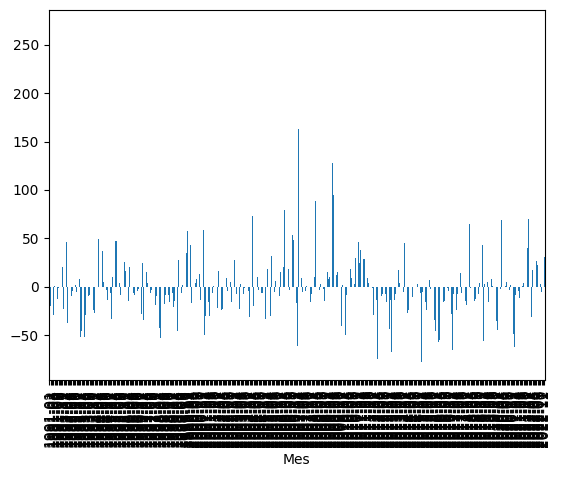

In [229]:
# Plot básico da anomalia.
df4.anomalia.plot.bar()

## Meses mais e menos chuvosos

In [230]:
df3

,Chuva,Media,anomalia
Mes,,,
1991-01-01,100.099648,100.709091,-0.609444
1991-02-01,79.893944,100.102196,-20.208252
1991-03-01,164.202332,127.645203,36.557129
1991-04-01,71.712448,101.075050,-29.362602
1991-05-01,56.974304,56.354694,0.619610
...,...,...,...
2022-08-01,35.391964,15.021799,20.370165
2022-09-01,14.892078,11.756269,3.135810
2022-10-01,16.885502,21.858221,-4.972719


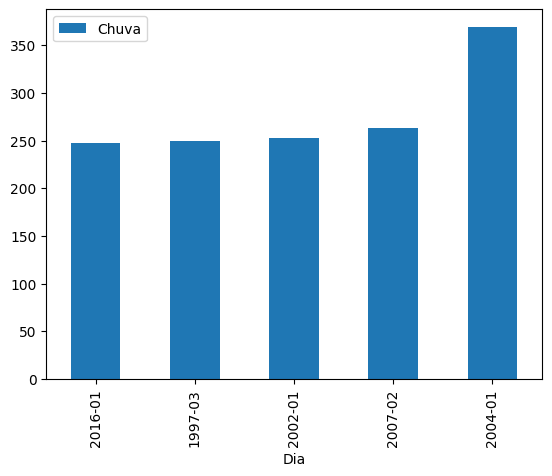

In [231]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html

# Remove o dia da série temporal.
df3 = chuva_acumulada.resample('M', kind='period').mean()

# Os 5 meses mais chuvosos.
meses_mais_chuvoso = df3.nlargest(5, 'Chuva')

# Ordena de forma crescente os valores dos meses mais chuvosos.
meses_ordem_crescente = meses_mais_chuvoso.sort_values(by='Chuva').plot.bar()

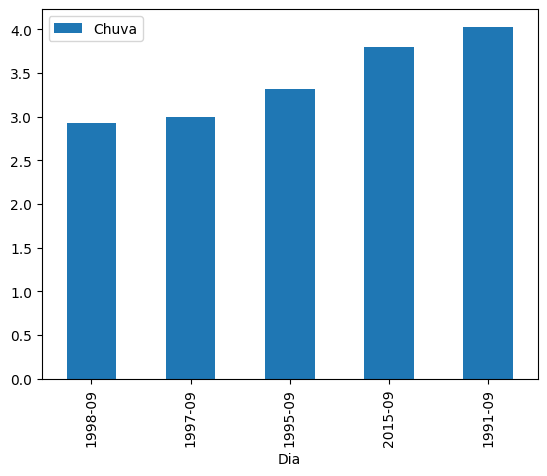

In [232]:
# Documentação
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nsmallest.html

# Os 5 meses menos chuvosos.
meses_menos_chuvoso = df3.nsmallest(5, 'Chuva')

# Ordena de forma crescente os valores dos meses mais chuvosos.
meses_ordem_crescente = meses_menos_chuvoso.sort_values(by='Chuva').plot.bar()